In [323]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import yfinance as yf
import math as m
from scipy.stats import norm

In [324]:
ticker = input("What stock would you like to predict ->").upper()
total = 3 * 365 # total days for histrorical data
trade_days = 252 # number of trading days in a year
n = 10000 # number of simulations

In [325]:
stock = yf.Ticker(ticker)
date_start = dt.date.today() - dt.timedelta(days = total)
data = stock.history(start = date_start)
data = data.drop(columns=['Volume','Dividends','Stock Splits'])


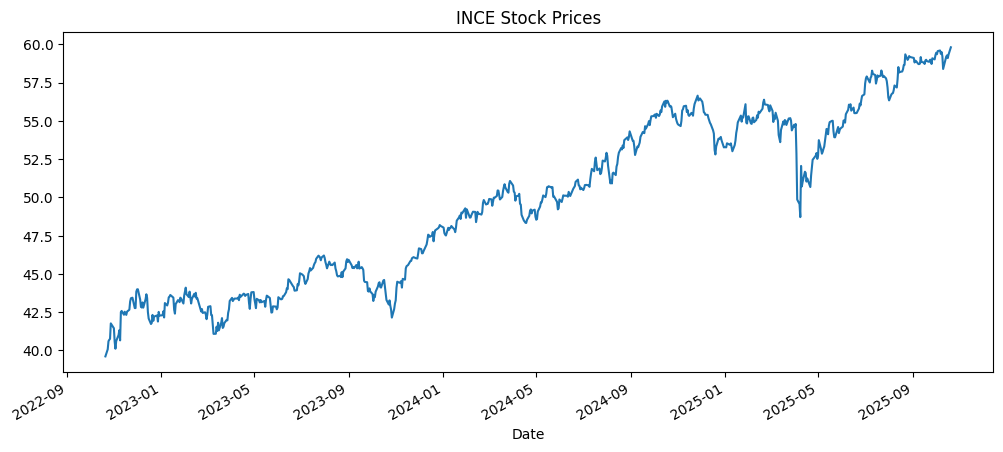

In [326]:
data["Close"].plot(figsize= (12,5))
plt.title(f"{ticker} Stock Prices")
plt.show()

In [327]:
data["Percent Change"] = data["Close"].pct_change() 
data["Log Change"] = np.log(data['Percent Change'] + 1)

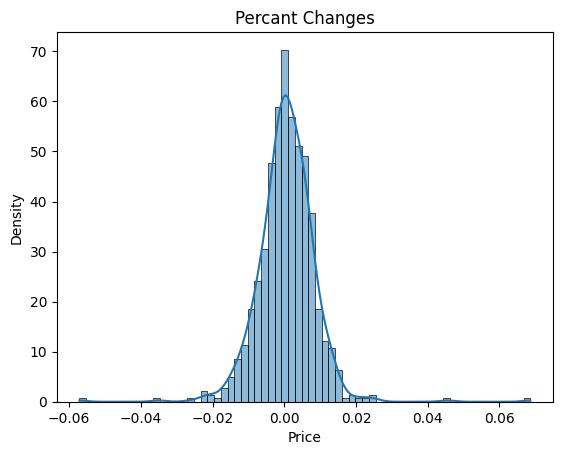

In [328]:
sns.histplot(data["Percent Change"], kde= True, bins='auto', stat='density')
plt.title("Percant Changes")
plt.xlabel("Price")
plt.show()

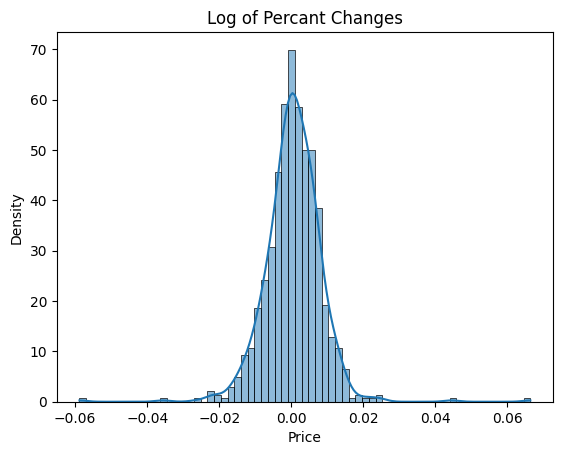

In [329]:
sns.histplot(data["Log Change"], kde= True, bins='auto', stat='density')
plt.title("Log of Percant Changes")
plt.xlabel("Price")
plt.show()

In [330]:
def GBM(data,num = 10000, days = 252, window = total):
    log_change = data["Log Change"][- window : ]
    mu = np.mean(log_change)
    std = np.std(log_change)
    drift = mu - (1/2) * (std**2)
    #z = np.random.normal(size=(days,num)) 

    # X = mu + sigma * Z where Z is N(0,1) gives N(mu,sigma^2)
    #delta_t = 1 as using daily increments and data for drift and volatility are daily closings
    z_updated = np.exp(np.random.normal(loc = drift, scale = std, size = (days,num))) 
    end = np.zeros(shape=(days+1,num))
    end[0] = data['Close'][-1]
    for i in range(1,days+1):
        end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
    return pd.DataFrame(end)

def ProbabilityOver(results,last_close, mu, sigma):
    np.array(results)
    last_close = round(last_close,2)
    print(f"Probabilty over last close ({last_close}) by count: {np.count_nonzero(results > last_close)/len(results)}")
    print(f"Probabilty over last close ({last_close}) by Log Normal: {round(1 - norm.cdf(m.log(last_close), mu, sigma),4)}") #approximation



In [331]:
sim_df = GBM(data, n, trade_days)
results = np.array(sim_df.iloc[-1])

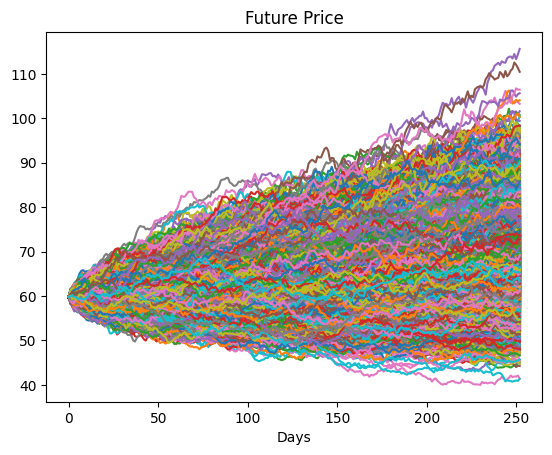

In [332]:
sim_df.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()

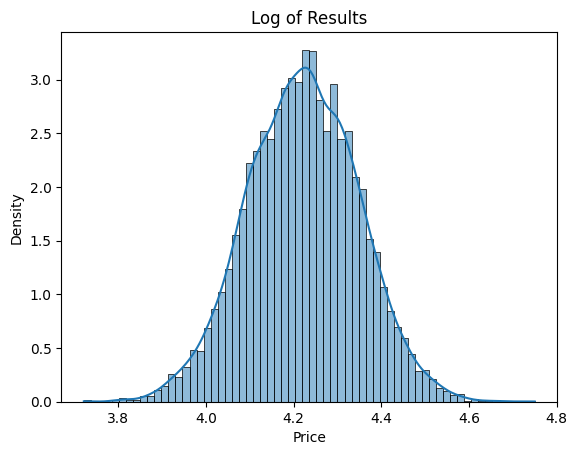

In [333]:
sns.histplot(np.log(results), kde= True, bins='auto', stat='density')
plt.title("Log of Results")
plt.xlabel("Price")
plt.show()

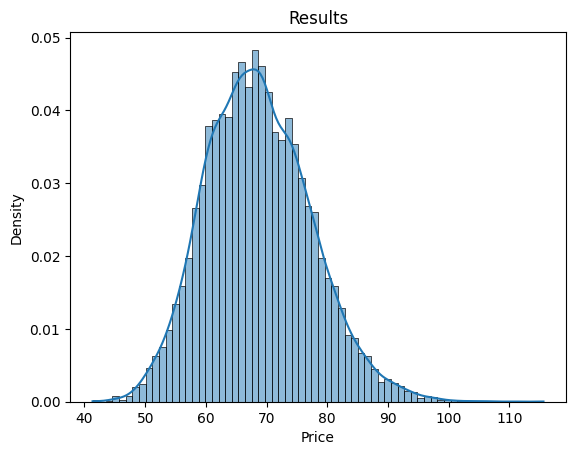

In [334]:
sns.histplot(results, kde= True, bins='auto', stat='density')
plt.title("Results")
plt.xlabel("Price")
plt.show()

In [335]:
expected = np.mean(results)
spread = np.std(results, ddof=1) #1/(n-1) sum(from i = 1 to n) (xi - Xbar)^2. which is used in the approximate pivot for CLT
clt_quant = 1.76
mle_mu = np.mean(np.log(results))
mle_sigma = np.std(np.log(results))

In [336]:
print(f"Price at last close: {round(data['Close'][-1],2)}")
print(f"Expected: {round(expected,2)} Deviation: {round(spread,2)}")
print(f"Median: {round(np.median(results),2)} ; Q1: {round(np.percentile(results,25),2)}  ; Q3 {round(np.percentile(results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print("\n"*2)
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(results,5),2)},{round(np.percentile(results,95),2)}]")

clt_upper = round(expected + (spread/(n**(1/2))) * clt_quant , 2) # using (Xbar - mu) / (S/sqrt(n) as an approximate pivot for confidence intervals 
clt_lower = round(expected - (spread/(n**(1/2))) * clt_quant , 2)
print(f"95% Confidence Interval for Real Expected Value of outcome: [{clt_lower},{clt_upper}]")

Price at last close: 59.8
Expected: 68.66 Deviation: 8.66
Median: 68.2 ; Q1: 62.43  ; Q3 74.34 ; IQR: 11.91



90% Confidence Interval for Outcome: [55.38,83.55]
95% Confidence Interval for Real Expected Value of outcome: [68.51,68.81]


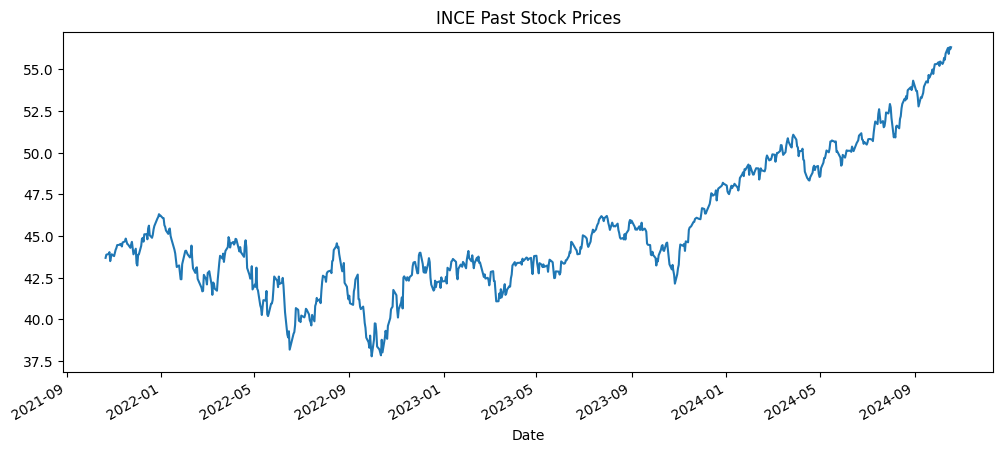

In [337]:
date_start = dt.date.today() - dt.timedelta(days = 365 + total)
new_data = stock.history(start = date_start)
new_data = new_data.drop(columns=['Volume','Dividends','Stock Splits'])

cutoff = pd.Timestamp(dt.date.today() - dt.timedelta(days = 364), tz= 'UTC') #exclusive end of slice
new_data = new_data.loc[:cutoff]
new_data["Percent Change"] = new_data["Close"].pct_change()
new_data["Log Change"] = np.log(new_data['Percent Change'] + 1)

new_data["Close"].plot(figsize= (12,5))

plt.title(f"{ticker} Past Stock Prices")
plt.show()

In [338]:
inclusive_cutoff = new_data.index[-1]
test_sim_df = GBM(new_data, n, len(data.loc[inclusive_cutoff:]['Close'])-1)
test_results = np.array(test_sim_df.iloc[-1]) #lognormal dist
test_expected = np.mean(test_results)
test_spread = np.std(test_results)

print(f"Price at last close: {round(new_data['Close'][-1],2)}")
print(f"Expected: {round(test_expected,2)} Deviation: {round(test_spread,2)}")
print(f"Median: {round(np.median(test_results),2)} ; Q1: {round(np.percentile(test_results,25),2)}  ; Q3 {round(np.percentile(test_results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(test_results,5),2)},{round(np.percentile(test_results,95),2)}]")
print(f"70% Confidence Interval for Outcome: [{round(np.percentile(test_results,15),2)},{round(np.percentile(test_results,85),2)}]")
print(f"Actual Price today: {round(data['Close'][-1],2)}")

Price at last close: 56.31
Expected: 61.41 Deviation: 8.58
Median: 60.87 ; Q1: 55.31  ; Q3 66.82 ; IQR: 11.91
90% Confidence Interval for Outcome: [48.44,76.34]
70% Confidence Interval for Outcome: [52.61,70.18]
Actual Price today: 59.8


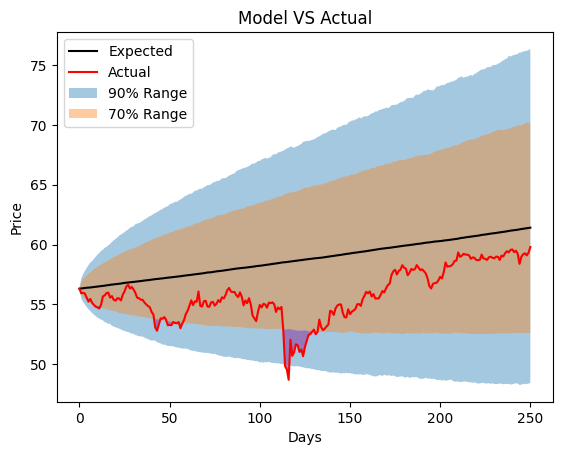

In [339]:
means = []
upper_90 = []
lower_90 = []
upper_70 = []
lower_70 = []

for i in range(len(test_sim_df.index)):
    means.append(np.mean(test_sim_df.iloc[i]))
    upper_90.append(np.percentile(test_sim_df.iloc[i],95))
    lower_90.append(np.percentile(test_sim_df.iloc[i],5))
    upper_70.append(np.percentile(test_sim_df.iloc[i],85))
    lower_70.append(np.percentile(test_sim_df.iloc[i],15))


fig, ax = plt.subplots()
ax.plot(range(len(means)),means, label = 'Expected', color = 'black')
ax.plot(range(len(means)),data.loc[inclusive_cutoff:]["Close"],label = 'Actual', color = 'red')

ax.fill_between(x = range(len(means)), y1=upper_90, y2=lower_90, alpha = .4, label = '90% Range')
ax.fill_between(range(len(means)), upper_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_90, fc='orange', alpha=0.4)
ax.fill_between(range(len(means)), lower_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_90, fc='orange', alpha=0.4)

ax.fill_between(x = range(len(means)), y1=upper_70, y2=lower_70, alpha = .4, label = '70% Range')
ax.fill_between(range(len(means)), upper_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_70, fc='purple', alpha=0.4)
ax.fill_between(range(len(means)), lower_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_70, fc='purple', alpha=0.4)

ax.set_title("Model VS Actual")
ax.set_xlabel("Days")
ax.set_ylabel("Price")
ax.legend(loc = 'upper left')
plt.show()